# Data Science Nigeria Staff Promotion Algorithm - XGBoost Complex
# Author - Toluwaniyi

In [0]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# Set all options
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (20, 3)
pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set(context="paper", font="monospace")

In [0]:
#Defined Functions
def convert_categorical_to_dummies(d_convert):
    
    """
    Author: Toluwaniyi
    Description: returns Dataframe with all categorical variables converted into dummies
    Arguments: Dataframe (having categorical variables)
    """
    
    df = d_convert.copy()
    list_to_drop = []
    for col in df.columns:
        if df[col].dtype == 'object':
            list_to_drop.append(col)
            df = pd.concat([df,pd.get_dummies(df[col],prefix=col,prefix_sep='_', drop_first=False)], axis=1)    
    df = df.drop(list_to_drop,axis=1)
    return df


def quality_report(df):

    """
    Author: Toluwaniyi
    Description: Displays quality of data in terms of missing values, unique numbers, datatypes etc.
    Arguments: Dataframe
    """
    dtypes = df.dtypes
    nuniq = df.T.apply(lambda x: x.nunique(), axis=1)
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    quality_df  = pd.concat([total, percent, nuniq, dtypes], axis=1, keys=['Total', 'Percent','Nunique', 'Dtype'])
    display(quality_df)
    

    
def object_count_plot(df):
    
    """
    Author: Toluwaniyi
    Description : Plot countplot for all the objects present in the dataframe passed
    Argument : Dataframe
    """
    
    for var in df.columns:
        if df[var].dtype == 'object':
            print(df[var].value_counts())
            plt.figure(figsize=(12,5))
            g = sns.countplot(x=var,data=df)
            g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
            plt.tight_layout()
            plt.show()
            
            
            

# Reading the Data

In [88]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [89]:
#Read the train set
data=pd.read_csv('gdrive/My Drive/DSN Project/train.csv')
print("Shape of Data = ",data.shape)
data.sample(5)


Shape of Data =  (38312, 19)


,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
18786,YAK/S/26794,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,2,1990,10.0000,2015,0,0,42,ENUGU,Yes,Married,No,No,1,0
3998,YAK/S/05629,Customer Support and Field Operations,"MSc, MBA and PhD",Male,Agency and others,2,1978,5.0000,2013,0,0,49,ANAMBRA,Yes,Married,No,No,0,0
7217,YAK/S/10211,Sourcing and Purchasing,First Degree or HND,Male,Direct Internal process,2,1994,7.5000,2015,0,0,57,AKWA IBOM,Yes,Married,No,No,1,0
11781,YAK/S/16749,Business Finance Operations,First Degree or HND,Male,Agency and others,4,1995,12.5000,2015,1,0,51,ONDO,Yes,Married,No,No,0,0
6291,YAK/S/08917,Information and Strategy,First Degree or HND,Male,Agency and others,2,1990,2.5000,2015,0,0,75,KANO,Yes,Married,No,Yes,0,0


Checking the event rate

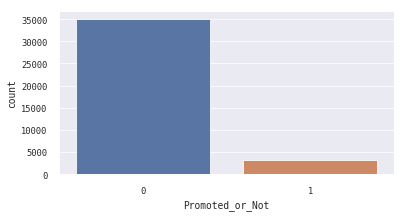

0    35071
1     3241
Name: Promoted_or_Not, dtype: int64

In [90]:
#We check the event rate
plt.figure(figsize=(6,3))
sns.countplot(x='Promoted_or_Not',data=data)
plt.show()

# Checking the event rate : event is when claim is made
data['Promoted_or_Not'].value_counts()

In [91]:
#Display attributes
pd.DataFrame(data.columns)

,0
0,EmployeeNo
1,Division
2,Qualification
3,Gender
4,Channel_of_Recruitment
5,Trainings_Attended
6,Year_of_birth
7,Last_performance_score
8,Year_of_recruitment
9,Targets_met


Checking for missing values

In [92]:
# checking missing data
quality_report(data)

,Total,Percent,Nunique,Dtype
Channel_of_Recruitment,0,0.0000,3,object
Division,0,0.0000,9,object
EmployeeNo,0,0.0000,38312,object
Foreign_schooled,0,0.0000,2,object
Gender,0,0.0000,2,object
Last_performance_score,0,0.0000,6,float64
Marital_Status,0,0.0000,3,object
No_of_previous_employers,0,0.0000,7,object
Past_Disciplinary_Action,0,0.0000,2,object
Previous_Award,0,0.0000,2,int64


Missing value treatment

In [0]:
# Treating the missing values of education as a separate category
data['Qualification'] = data['Qualification'].replace(np.NaN, 'NA')

#Convert Year of birth to Age
data = data.rename(columns = {'Year_of_birth': 'Age'})
data['Age'] = 2019 - data['Age']

#Convert the 'Year_of_recruitment' to number of years in company by subtracting from the year 2019
data = data.rename(columns ={'Year_of_recruitment': 'Years_in_company'})
data['Years_in_company'] = 2019 - data['Years_in_company']

#We replace all entries of 'More than 5' with 6 and convert the column type to integer
data['No_of_previous_employers'] = data['No_of_previous_employers'].replace(regex = 'More than 5', value = 6)
data['No_of_previous_employers'] = data['No_of_previous_employers'].astype(int)

#Drop EmployeeNo and State_Of_Origin columns as these have little to no effect on our target variable
data = data.drop(['State_Of_Origin','EmployeeNo'],axis=1)

In [94]:
# Checking number of unique values in each column, just to confirm if there are multiple values in it.
quality_report(data)

,Total,Percent,Nunique,Dtype
Age,0,0.0000,49,int64
Channel_of_Recruitment,0,0.0000,3,object
Division,0,0.0000,9,object
Foreign_schooled,0,0.0000,2,object
Gender,0,0.0000,2,object
Last_performance_score,0,0.0000,6,float64
Marital_Status,0,0.0000,3,object
No_of_previous_employers,0,0.0000,7,int64
Past_Disciplinary_Action,0,0.0000,2,object
Previous_Award,0,0.0000,2,int64


# Analyze the attributes from the dataset

- Promotions are most likely in the Information Technology and Solution Support Departments and least likely in Regulatory and Legal Services
- Post-graduate degree holders are most likely to be promoted, though the difference is small
-Referrals and Special candidates are far more likely to be promoted than people who were recruited via other means
- Employees who met their annual target are most likely to be promoted
- Employees who have previously been awarded are far more likely to be promoted
- Schooling, Gender, Marital Status etc have very little or no role to play in the promotion of employees

In [95]:
for col in data.drop('Promoted_or_Not',axis=1).columns:
    if data[col].dtype == 'object' or data[col].nunique() < 10:
        xx = data.groupby(col)['Promoted_or_Not'].value_counts().unstack(1)
        per_not_promoted = xx.iloc[:, 0] *100/xx.apply(lambda x: x.sum(), axis=1)
        per_promoted = xx.iloc[:, 1]*100/xx.apply(lambda x: x.sum(), axis=1)
        xx['%_0'] = per_not_promoted
        xx['%_1'] = per_promoted
        display(xx)

Promoted_or_Not,0,1,%_0,%_1
Division,,,,
Business Finance Operations,1640,146,91.8253,8.1747
Commercial Sales and Marketing,10854,841,92.8089,7.1911
Customer Support and Field Operations,7269,704,91.1702,8.8298
Information Technology and Solution Support,4420,532,89.2569,10.7431
Information and Strategy,3373,348,90.6477,9.3523
People/HR Management,1607,97,94.3075,5.6925
Regulatory and Legal services,692,41,94.4065,5.5935
Research and Innovation,653,43,93.8218,6.1782
Sourcing and Purchasing,4563,489,90.3207,9.6793


Promoted_or_Not,0,1,%_0,%_1
Qualification,,,,
First Degree or HND,23483,2095,91.8094,8.1906
"MSc, MBA and PhD",9457,1012,90.3334,9.6666
NA,1597,82,95.1161,4.8839
Non-University Education,534,52,91.1263,8.8737


Promoted_or_Not,0,1,%_0,%_1
Gender,,,,
Female,10414,1018,91.0952,8.9048
Male,24657,2223,91.7299,8.2701


Promoted_or_Not,0,1,%_0,%_1
Channel_of_Recruitment,,,,
Agency and others,19514,1796,91.5720,8.4280
Direct Internal process,14847,1347,91.6821,8.3179
Referral and Special candidates,710,98,87.8713,12.1287


Promoted_or_Not,0,1,%_0,%_1
Last_performance_score,,,,
0.0000,2659,246,91.5318,8.4682
2.5000,4266,59,98.6358,1.3642
5.0000,2806,138,95.3125,4.6875
7.5000,12059,934,92.8115,7.1885
10.0000,6367,565,91.8494,8.1506
12.5000,6914,1299,84.1836,15.8164


Promoted_or_Not,0,1,%_0,%_1
Targets_met,,,,
0,23835,953,96.1554,3.8446
1,11236,2288,83.0819,16.9181


Promoted_or_Not,0,1,%_0,%_1
Previous_Award,,,,
0,34582,2843,92.4035,7.5965
1,489,398,55.1297,44.8703


Promoted_or_Not,0,1,%_0,%_1
Foreign_schooled,,,,
No,3046,271,91.8300,8.1700
Yes,32025,2970,91.5131,8.4869


Promoted_or_Not,0,1,%_0,%_1
Marital_Status,,,,
Married,28386,2636,91.5028,8.4972
Not_Sure,324,39,89.2562,10.7438
Single,6361,566,91.8291,8.1709


Promoted_or_Not,0,1,%_0,%_1
Past_Disciplinary_Action,,,,
No,34936,3225,91.5490,8.4510
Yes,135,16,89.4040,10.5960


Promoted_or_Not,0,1,%_0,%_1
Previous_IntraDepartmental_Movement,,,,
No,31747,2962,91.4662,8.5338
Yes,3324,279,92.2565,7.7435


Promoted_or_Not,0,1,%_0,%_1
No_of_previous_employers,,,,
0,12179,1093,91.7646,8.2354
1,17253,1614,91.4454,8.5546
2,1742,176,90.8238,9.1762
3,1452,135,91.4934,8.5066
4,1203,121,90.8610,9.1390
5,872,71,92.4708,7.5292
6,370,31,92.2693,7.7307


##PREPARE DATA FOR MODELLING

In [96]:
# Creating dummy variables for all the categorical columns, dropping that column
master_data = convert_categorical_to_dummies(data)
print("Total shape of Data :",master_data.shape)

Total shape of Data : (38312, 36)


In [97]:
# dropping the target from dataset
labels = np.array(master_data['Promoted_or_Not'].tolist())

# Removing the id attributes
df_data = master_data.drop(['Promoted_or_Not'],axis=1)
print("Shape of Data:",df_data.shape)
df = df_data.values

Shape of Data: (38312, 35)


## MODEL 1 XGB CLASSIFIER

BaseLine Model

In [98]:
xgb_model = xgb.XGBClassifier()
print(xgb_model)

# Cross validation scores
f1_scores = cross_val_score(xgb_model, df, labels, cv=5, scoring='f1')
print(f1_scores," Mean = ",np.mean(f1_scores))

# Training the models
xgb_model.fit(df,labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
[0.44205496 0.41737033 0.45700824 0.433213   0.46298472]  Mean =  0.4425262498231778


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## PREPARE TEST SET FOR SCORING

In [0]:
test = pd.read_csv('gdrive/My Drive/DSN Project/test.csv')
test_data = test.copy()
    
# Treating the missing values of education as a separate category
test_data['Qualification'] = test_data['Qualification'].replace(np.NaN, 'NA')

#Convert Year of birth to Age
test_data = test_data.rename(columns = {'Year_of_birth': 'Age'})
test_data['Age'] = 2019 - data['Age']

#Convert the 'Year_of_recruitment' to number of years in company by subtracting from the year 2019
test_data = test_data.rename(columns ={'Year_of_recruitment': 'Years_in_company'})
test_data['Years_in_company'] = 2019 - test_data['Years_in_company']

#We replace all entries of 'More than 5' with 6 and convert the column type to integer
test_data['No_of_previous_employers'] = test_data['No_of_previous_employers'].replace(regex = 'More than 5', value = 6)
test_data['No_of_previous_employers'] = test_data['No_of_previous_employers'].astype(int)

test_data = test_data.drop(['State_Of_Origin','EmployeeNo'],axis=1)

# Creating dummy variables for all the categorical columns, dropping that column
master_test_data = convert_categorical_to_dummies(test_data)

Scoring on Test Set

In [115]:
y_pred = xgb_model.predict(master_test_data.values)

submission_df = pd.DataFrame({'EmployeeNo':test['EmployeeNo'],'Promoted_or_Not':y_pred})
submission_df['Promoted_or_Not']

submission_df['Promoted_or_Not'].value_counts()

0    16078
1      418
Name: Promoted_or_Not, dtype: int64

In [0]:
score = xgb_model.predict_proba(master_test_data.values)
print(score)

## Export Predictions as csv file

In [0]:
from google.colab import files

submission_df.to_csv('DNS_XGBoost_Predict.csv') 
files.download('DNS_XGBoost_Predict.csv')

## XGB Classifier : Parameter Tuning - [improve the training and increase score in terms of F1-score]

In [116]:
# Create parameters to search
params = {
     'learning_rate': [0.01],
     'n_estimators': [1000],
     'max_depth':[8],
     'reg_alpha':[0.4]
    }

# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier()

# Gridsearch initializaation
gsearch = GridSearchCV(xgb_model, params,
                    verbose=True,
                    cv=5,
                    n_jobs=2)

gsearch.fit(df, labels)

#Printing the best chosen params
print(gsearch.best_params_)

params = {'objective':'binary:logistic', 'booster':'gbtree'}

# Updating the parameter as per grid search
params.update(gsearch.best_params_)

# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier(**params)
print(xgb_model)

# Cross validation scores
f1_scores = cross_val_score(xgb_model, df, labels, cv=5, scoring='f1',n_jobs=2)
print(f1_scores," Mean = ",np.mean(f1_scores))

# Fitting model on tuned parameters
xgb_model.fit(df, labels)



#RUN SAME PREPROCESSING AS CARRIED OUT ON PREVIOUS TEST SET

test_data = test.copy()
    
# Treating the missing values of education as a separate category
test_data['Qualification'] = test_data['Qualification'].replace(np.NaN, 'NA')

#Convert Year of birth to Age
test_data = test_data.rename(columns = {'Year_of_birth': 'Age'})
test_data['Age'] = 2019 - data['Age']

#Convert the 'Year_of_recruitment' to number of years in company by subtracting from the year 2019
test_data = test_data.rename(columns ={'Year_of_recruitment': 'Years_in_company'})
test_data['Years_in_company'] = 2019 - test_data['Years_in_company']

#We replace all entries of 'More than 5' with 6 and convert the column type to integer
test_data['No_of_previous_employers'] = test_data['No_of_previous_employers'].replace(regex = 'More than 5', value = 6)
test_data['No_of_previous_employers'] = test_data['No_of_previous_employers'].astype(int)

test_data = test_data.drop(['State_Of_Origin','EmployeeNo'],axis=1)

# Creating dummy variables for all the categorical columns, dropping that column
master_test_data = convert_categorical_to_dummies(test_data)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  5.1min finished


{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000, 'reg_alpha': 0.4}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
[0.50505051 0.46788991 0.48758465 0.52863436 0.48933782]  Mean =  0.4956994494649778


0    15986
1      510
Name: Promoted_or_Not, dtype: int64

Score and Predict 

In [0]:
y_pred = xgb_model.predict(master_test_data.values)
#Convert to a dataframe
submission_tuned_df = pd.DataFrame({'EmployeeNo':test['EmployeeNo'],'Promoted_or_Not':y_pred})

score = xgb_model.predict_proba(master_test_data.values)
print(score)

submission_tuned_df['Promoted_or_Not'].value_counts()

## Export Predictions as CSV file

In [0]:
submission_tuned_df.to_csv('DNS_XGBoostuned_Predict.csv') 
files.download('DNS_XGBoostuned_Predict.csv')